


        Date       Pax
0 2003-01-01  47938280
1 2003-02-01  45412146
2 2003-03-01  55001313
3 2003-04-01  51378704
4 2003-05-01  53763186


                        R2           MAE           MSE          RMSE
Regresión Lineal -0.323685  1.721966e+07  6.620755e+14  2.573083e+07
Random Forest    -0.645189  1.873365e+07  8.228841e+14  2.868596e+07
ARIMA            -1.048078  2.439221e+07  1.024400e+15  3.200624e+07


                        R2           MAE           MSE          RMSE
Regresión Lineal -0.396642  7.542465e+06  8.318995e+13  9.120852e+06
Random Forest     0.468830  4.971609e+06  3.163877e+13  5.624835e+06
ARIMA             0.670698  3.067302e+06  1.961464e+13  4.428841e+06


Se escoge el modelo con el mejor R2


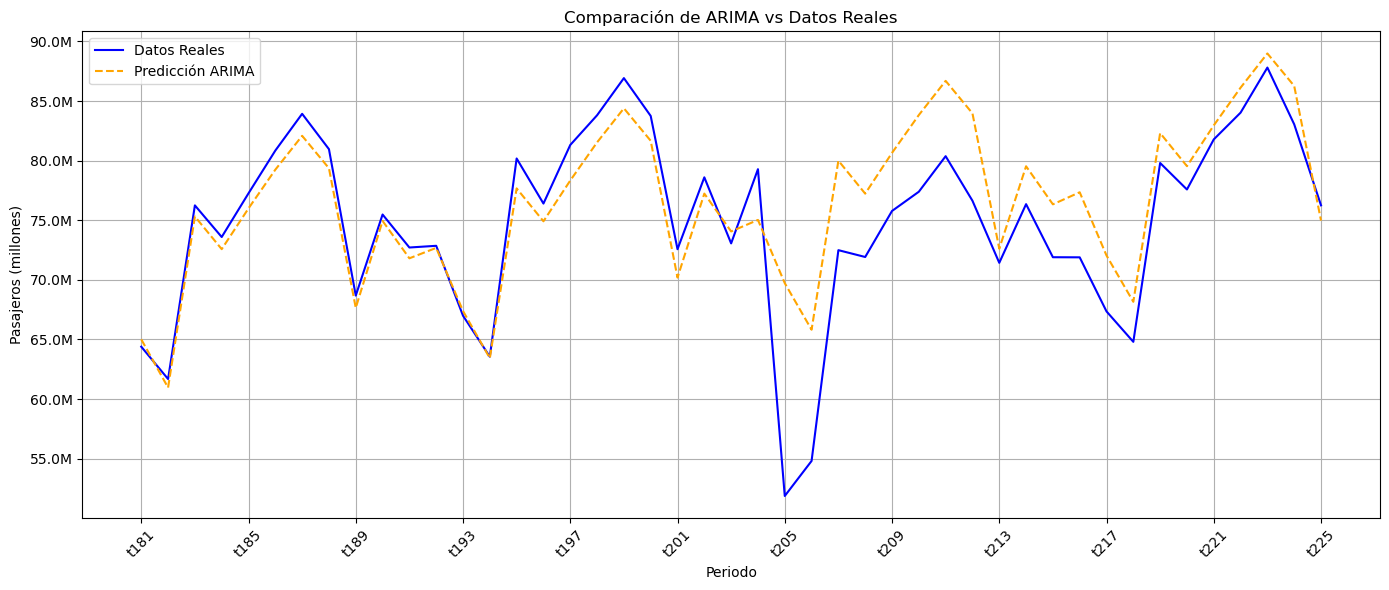

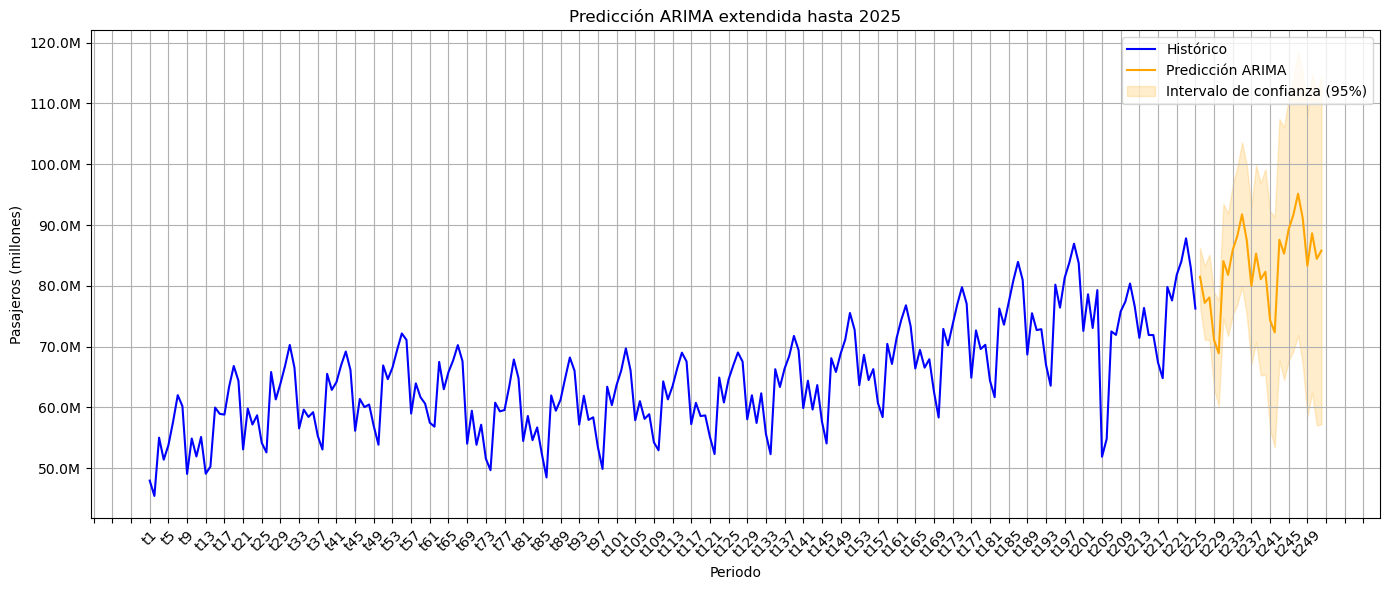

          Date Periodo Prediccion_Pax_M Lower_CI_M Upper_CI_M
225 2023-10-01    t226            81.5M      76.7M      86.2M
226 2023-11-01    t227            77.2M      71.2M      83.2M
227 2023-12-01    t228            78.1M      71.0M      85.1M
228 2024-01-01    t229            71.1M      63.1M      79.0M
229 2024-02-01    t230            68.9M      60.2M      77.6M
230 2024-03-01    t231            84.1M      74.7M      93.5M
231 2024-04-01    t232            81.8M      71.7M      91.9M
232 2024-05-01    t233            85.9M      75.2M      96.6M
233 2024-06-01    t234            88.2M      76.9M      99.5M
234 2024-07-01    t235            91.8M      79.9M     103.6M
235 2024-08-01    t236            87.5M      75.1M      99.9M
236 2024-09-01    t237            80.0M      67.1M      92.9M
237 2024-10-01    t238            85.3M      70.7M      99.9M
238 2024-11-01    t239            81.1M      65.3M      96.9M
239 2024-12-01    t240            82.3M      65.4M      99.2M
240 2025

In [47]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")
print()
print()
print()

df = pd.read_csv('air_traffic_final.csv')
# Crear la columna de fecha

df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

# Seleccionar solo columnas relevantes
df_model = df[['Date', 'Pax']].copy()


# Mostrar las primeras filas del DataFrame resultante
print(df_model.head())
print()
print()



# Crear variables numéricas a partir de la fecha
df_model['Year'] = df_model['Date'].dt.year
df_model['Month'] = df_model['Date'].dt.month
# Variables predictoras
X = df_model[['Year', 'Month']]
y = df_model['Pax']

# División Test entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# -------------------------------
# 1. Regresión lineal
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# 2. Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 3. ARIMA (SARIMAX simple con orden automático)

train_size = int(len(df_model) * 0.8)
train_arima = df_model['Pax'][:train_size]
test_arima = df_model['Pax'][train_size:]

# Entrenamos un modelo SARIMAX simple
arima_model = sm.tsa.SARIMAX(train_arima, order=(1,1,1), seasonal_order=(1,1,1,12))
arima_result = arima_model.fit(disp=False)
y_pred_arima = arima_result.predict(start=len(train_arima), end=len(df_model)-1, typ='levels')

# Función para evaluar
def evaluate_model(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False)
    }

# Evaluar todos los modelos
results = {
    "Regresión Lineal": evaluate_model(y_test, y_pred_lr),
    "Random Forest": evaluate_model(y_test, y_pred_rf),
    "ARIMA": evaluate_model(test_arima, y_pred_arima)
}

results


df_results = pd.DataFrame(results).T  


print(df_results)


df_results.to_excel("resultados_modelos_Predictivos_1.xlsx", index=True)

# Crear variables numéricas a partir de la fecha
#df_model['Year'] = df_model['Date'].dt.year
#df_model['Month'] = df_model['Date'].dt.month

# Filtramos los datos para eliminar el periodo de marzo 2020 a mayo 2021 (periodo de mayor impacto por COVID)
#df_filtered = df_model[(df_model['Date'] < '2020-03-01') | (df_model['Date'] > '2021-05-31')].copy()


# Filtramos los datos para eliminar los años 2020 y 2021 (periodo de mayor impacto por COVID)
df_filtered = df_model[~df_model['Year'].isin([2020, 2021])].copy()


# Añadimos la columna de periodo secuencial (t1, t2, ...)
df_filtered = df_filtered.sort_values('Date')
df_filtered = df_filtered.reset_index(drop=True)
df_filtered['Periodo'] = ['t' + str(i + 1) for i in range(len(df_filtered))]

# Repetimos el proceso de preparación
X = df_filtered[['Year', 'Month']]
y = df_filtered['Pax']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Regresión Lineal
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# ARIMA (sobre la serie Pax directamente)
train_size = int(len(df_filtered) * 0.8)
train_arima = df_filtered['Pax'][:train_size]
test_arima = df_filtered['Pax'][train_size:]

arima_model = sm.tsa.SARIMAX(train_arima, order=(1,1,1), seasonal_order=(1,1,1,12))
arima_result = arima_model.fit(disp=False)
y_pred_arima = arima_result.predict(start=len(train_arima), end=len(df_filtered)-1, typ='levels')

print()
print()
# Evaluamos nuevamente
results_filtered = {
    "Regresión Lineal": evaluate_model(y_test, y_pred_lr),
    "Random Forest": evaluate_model(y_test, y_pred_rf),
    "ARIMA": evaluate_model(test_arima, y_pred_arima)
}

results_filtered

df_results = pd.DataFrame(results_filtered).T  
print(df_results)

print()
print()
print('Se escoge el modelo con el mejor R2')
df_results.to_excel("resultados_Modelos_Predictivos_2.xlsx", index=True)

# Entrenamos ARIMA sobre todos los datos limpios (sin COVID)
full_series = df_filtered.set_index('Date')['Pax']

# Reentrenamos el modelo ARIMA sobre toda la serie conocida
model = sm.tsa.SARIMAX(full_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# Realizamos predicciones para los próximos 27 meses (de octubre 2023 a diciembre 2025)
forecast_extended = model_fit.get_forecast(steps=27)
forecast_index_extended = pd.date_range(start=full_series.index[-1] + pd.DateOffset(months=1), periods=27, freq='MS')
forecast_mean_extended = forecast_extended.predicted_mean
forecast_ci_extended = forecast_extended.conf_int()

forecast_df_extended = pd.DataFrame({
    "Date": forecast_index_extended,
    "Forecast_Pax": forecast_mean_extended,
    "Lower_CI": forecast_ci_extended.iloc[:, 0],
    "Upper_CI": forecast_ci_extended.iloc[:, 1]
})

# Crear la columna de periodos para forecast (tN en adelante)
last_period = len(df_filtered)
forecast_df_extended['Periodo'] = ['t' + str(i + 1) for i in range(last_period, last_period + len(forecast_df_extended))]

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator

def millones(x, pos):
    return f'{x * 1e-6:.1f}M'

# Serie con índice ficticio para gráfico extendido
full_series_with_period = df_filtered.set_index('Periodo')['Pax']

# Gráfico 1: Comparación ARIMA vs Real
plt.figure(figsize=(14, 6))
df_comparacion = pd.DataFrame({
    "Periodo": df_filtered['Periodo'].iloc[-len(y_pred_arima):],
    "Real": test_arima.values,
    "Predicho_ARIMA": y_pred_arima.values
})
plt.plot(df_comparacion['Periodo'], df_comparacion['Real'], label='Datos Reales', color='blue')
plt.plot(df_comparacion['Periodo'], df_comparacion['Predicho_ARIMA'], label='Predicción ARIMA', color='orange', linestyle='--')
plt.title("Comparación de ARIMA vs Datos Reales")
plt.xlabel("Periodo")
plt.ylabel("Pasajeros (millones)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(millones))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MultipleLocator(4))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print()
print()

# Gráfico 2: Predicción extendida
plt.figure(figsize=(14, 6))
plt.plot(full_series_with_period.index, full_series_with_period.values, label='Histórico', color='blue')
plt.plot(forecast_df_extended['Periodo'], forecast_df_extended['Forecast_Pax'], label='Predicción ARIMA', color='orange')
plt.fill_between(
    forecast_df_extended['Periodo'],
    forecast_df_extended['Lower_CI'],
    forecast_df_extended['Upper_CI'],
    color='orange', alpha=0.2, label='Intervalo de confianza (95%)')
plt.title("Predicción ARIMA extendida hasta 2025")
plt.xlabel("Periodo")
plt.ylabel("Pasajeros (millones)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(millones))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MultipleLocator(4))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Filtrar las predicciones entre 2023 y 2025
forecast_filtered = forecast_df_extended[
    (forecast_df_extended['Date'] >= '2023-10-01') & 
    (forecast_df_extended['Date'] <= '2025-12-31')
].copy()

# Agregar columnas formateadas a millones con una cifra decimal y "M"
forecast_filtered['Prediccion_Pax_M'] = (forecast_filtered['Forecast_Pax'] / 1e6).round(1).astype(str) + 'M'
forecast_filtered['Lower_CI_M'] = (forecast_filtered['Lower_CI'] / 1e6).round(1).astype(str) + 'M'
forecast_filtered['Upper_CI_M'] = (forecast_filtered['Upper_CI'] / 1e6).round(1).astype(str) + 'M'

# Mostrar todas las filas en consola
pd.set_option('display.max_rows', None)

#print('Predicción ARIMA de 202310 a 202512 en millones)
print(forecast_filtered[['Date', 'Periodo', 'Prediccion_Pax_M', 'Lower_CI_M', 'Upper_CI_M']])

# Guardar en Excel
forecast_filtered.to_excel("prediccion_2023_2025.xlsx", index=False)



